In [32]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from tqdm.auto import tqdm

# Задача
Имеются результаты A/B теста

Понять увеличилась ли прибыль

Проверить для разных статистических тестов (в реальных задачах так лучше не делать)

------------------

# Данные

### Загрузка и преобразование

In [33]:
df = pd.read_csv('profit.csv', sep=';', index_col=0, decimal=',')

In [34]:
df = df.rename(columns={'experimentVariant': 'group'})

In [35]:
df

,value,group
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


- value – значения метрики
- group – Вариант теста (Control – контроль, Treatment – тест)

In [36]:
df.dtypes

value    float64
group     object
dtype: object

### Разведочный анализ

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1000 non-null   float64
 1   group   1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


In [38]:
df.group.value_counts()

Control      500
Treatment    500
Name: group, dtype: int64

In [39]:
df.query('group == "Control"').describe()

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


In [40]:
df.query('group == "Treatment"').describe()

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


Судя по квантилям распределения довольно похожи\
Отличия заметны в средних и максимальных значениях => во 2м распределении имеются выбросы

#### Визуализация

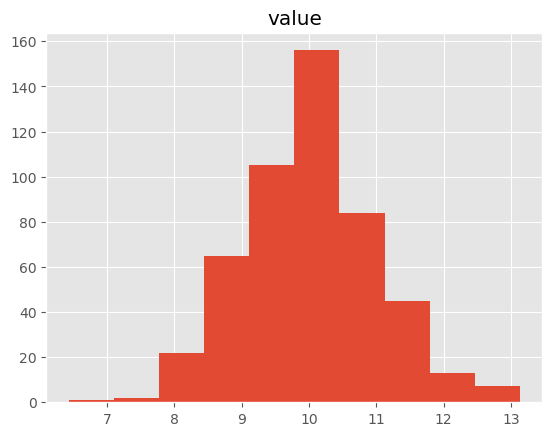

In [41]:
df.query('group == "Control"').hist();

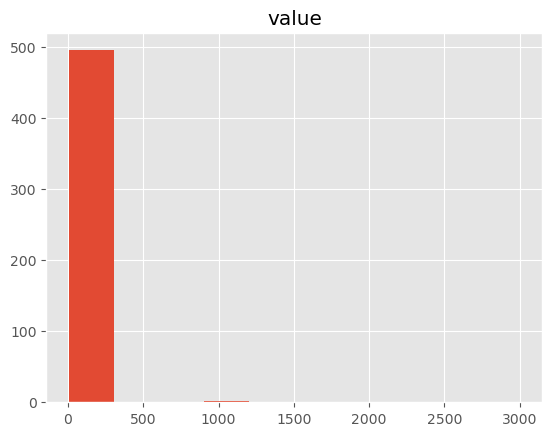

In [42]:
plt.style.use('ggplot')
df.query('group == "Treatment"').hist();

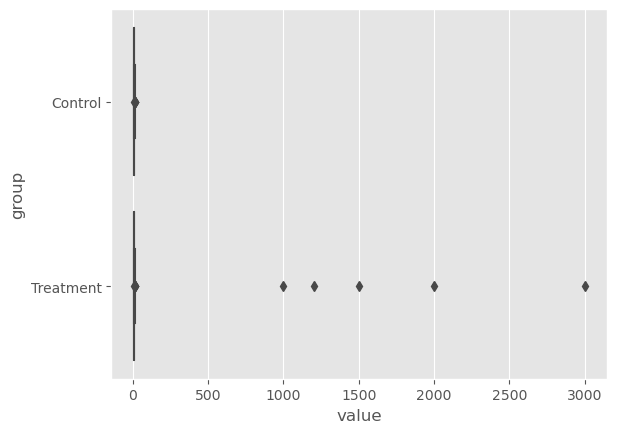

In [43]:
sns.boxplot(data=df, x='value', y='group');

В тестовой выборке имеются явные выбросы

Сравнение распределений, если избавиться от выбросов в тестовом распределении

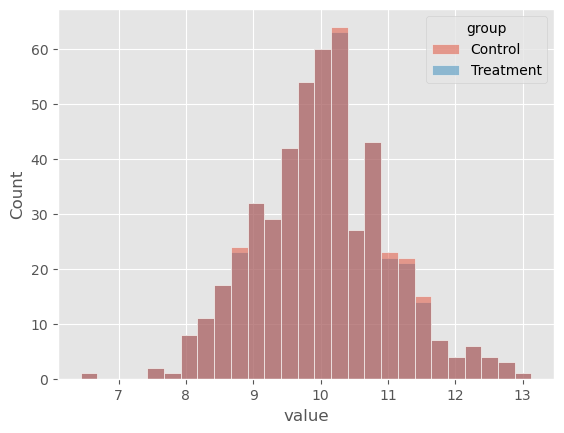

In [44]:
outlier_th = 20  # Порог для выбросов
sns.histplot(data=df.query('value < @outlier_th'), x='value', hue='group');

=> распределения визуально идентичны \
=> основное отличие распределений - выбросы в тестовой выборке

In [45]:
outliers = df.query('value >= @outlier_th')
outliers.value_counts('group')

group
Treatment    5
dtype: int64

_Проверка распределений на нормальность_

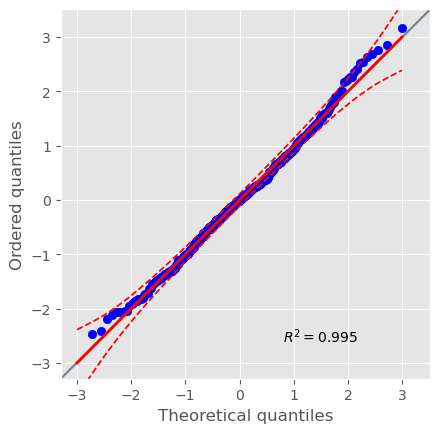

In [46]:
pg.qqplot(x=df.query('group == "Control"').value);

In [47]:
st.normaltest(df.query('group == "Control"').value)

NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)

=> распределение контрольной выборки можно считать нормальным

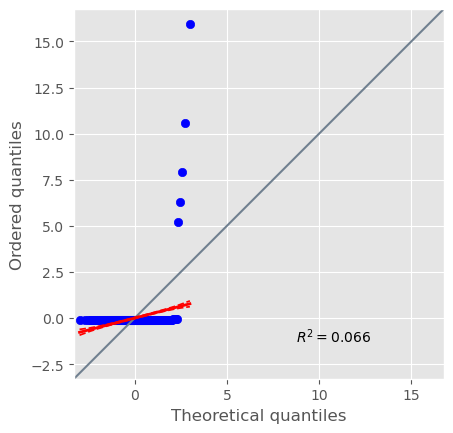

In [48]:
pg.qqplot(x=df.query('group == "Treatment"').value);

In [49]:
st.normaltest(df.query('group == "Treatment"').value)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

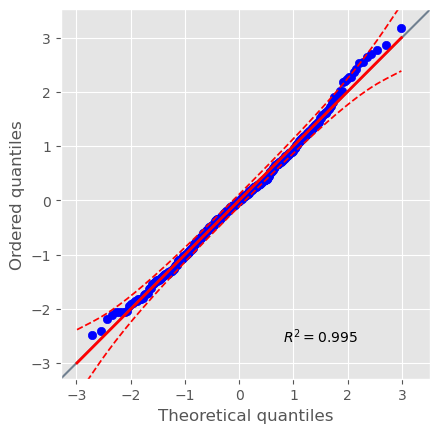

In [50]:
pg.qqplot(x=df.query('group == "Treatment" and value < @outlier_th').value);

In [51]:
st.normaltest(df.query('group == "Treatment" and value < @outlier_th').value)

NormaltestResult(statistic=3.4264513588191425, pvalue=0.18028331749803517)

=> распределение тестовой выборки без выбосов можно считать норсмальным. С выбросами - нет

#### Выводы
- в группе Treatment имеются несколько явных выбросов
- распределения без явных выбросов визуально очень похожи
- распределения без явных выбросов можно считать нормальными
- основной вопрос - что делать с явными выбросами? (поскольку сильно влияют на описательную статистику)

#### Идеи по работе с выбросами
- Отбрасывать выбросы (плохая идея, ведь эти наблюдения мб следствием нововведений в продукт, а не ошибкой)
- оставить

Попробую провести анализ с наличием выбросов

--------------

# Функции

In [52]:
def bootstrap_test(
    s1,
    s2,
    n_ss=5000,
    statistic_func=np.mean,
    conf_level=0.95,
    hist_n_bins=100,
    p_val_evaluation=False,
    print_info=True
):
    '''
    Функция для проверки гипотез с помощью bootstrap
    
    Parameters
    ----------
    s1: pandas.Series
        Выборка 1
    s2: pandas.Series
        Выборка 2
    n_ss: int, default 5000
        Количество bootstrap подвыборок (bootstrab subsamples)
        bootstrap подвыборка - подвыборка с повторениями
    statistic_func: function, default np.mean
        Функция для вычисления интересующей статистики
    conf_level: float, default 0.95
        Уровень значимости
    hist_n_bins: int, default 100
        Количество столбиков для гистограммы
    p_val_evaluation: bool, default False
        Оценка p-value с помощью нормального распределения
    print_info: bool, default True
        Вывод на экран информации (в т.ч. красивого графика)
        
    Returns
    -------
    is_0_in_ci: bool
        Находится ли 0 в ДИ
    boot_data: pandas.Series
        Расрпределение разницы метрик бутстрап выборок
    quantiles: dict
        Словарь с квантилями
    '''
    # Размер бутстрап подвыборок
    ss1_size = len(s1)
    ss2_size = len(s2)
    
    # Распределение разницы статистик подвыборок
    boot_data = []
    if print_info:
        for i in tqdm(range(n_ss)):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))
    else:
        for i in range(n_ss):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))
    
    boot_data = pd.Series(boot_data)
    
    # Вычисление квантилей
    left_quant = (1 - conf_level) / 2
    right_quant = 1 - left_quant
    quantiles = boot_data.quantile([left_quant, right_quant])
    quantiles.columns = ['value']
    
    # Статзначимость отличий выборок
    if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:
        is_0_in_ci = True
    else:
        is_0_in_ci = False
    
    # Вычисление p-value 
    # (из предположения, что распределение разницы статистик подвыборок - нормальное)
    if p_val_evaluation:
        p_1 = st.norm.cdf(
            x=0,
            loc=boot_data.mean(), 
            scale=boot_data.std()
        )
        p_2 = st.norm.cdf(
            x=0, 
            loc=-boot_data.mean(),
            scale=boot_data.std()
        )
        p_value = min(p_1, p_2) * 2  # Двустороння вероятность нулевых отличий распределений
        
    # Визуализация
    if print_info:
        hist_ys = []
        _, _, bars = plt.hist(boot_data, bins=hist_n_bins)
        for bar in bars:
            hist_ys.append(bar.get_height())
            bar.set_edgecolor('black')
            if quantiles.iloc[0] < bar.get_x() <= quantiles.iloc[1]:
                # Столбик в ДИ
                bar.set_facecolor('grey')
            else: 
                bar.set_facecolor('red')
        plt.style.use('ggplot')
        plt.vlines(quantiles, ymin=0, ymax=max(hist_ys), linestyle='--')  # Отображение квантилей
        if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:  # Подсветка нуля
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='green')
        else:
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='red')
        plt.xlabel('metric difference')
        plt.ylabel('frequency')
        plt.title("Subsamples metric difference")
        plt.show()
        if p_val_evaluation:
            print(f'p-value: {p_value}')
    
    return is_0_in_ci, boot_data, quantiles

----------------------

# Решение

df без выбросов

In [53]:
fixed_df = df.query('value < @outlier_th')
fixed_df

,value,group
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
991,10.916229,Treatment
992,11.160869,Treatment
993,8.202518,Treatment
994,9.782199,Treatment


### t-тест

Требования
- отсутствие выбросов (нет)
- гомогенность дисперсии в группах
- нормальность распределения (желательно)

_Отсутствие выбросов_ - в отфильтрованном df

_Гомогенность дисперсии_

In [54]:
st.levene(
    fixed_df.query('group == "Control"').value,
    fixed_df.query('group == "Treatment"').value
)

LeveneResult(statistic=0.004297981921358907, pvalue=0.9477421313655946)

=> дисперсия в группах без выбросов однородна

**Вывод:** t-тест неприменим для исходного df в силу наличия выбросов, но если их отфильтровать, то t-test для сравнения выборок подходит

In [55]:
st.ttest_ind(
    fixed_df.query('group == "Control"').value, 
    fixed_df.query('group == "Treatment"').value
)

Ttest_indResult(statistic=0.08299135107595523, pvalue=0.9338751428058142)

=> t-тест не позволяет отвергнуть H0

### U-тест

Требования
- нет часто повторяющихся наблюдений

In [56]:
df.query('group == "Control"').value.value_counts().sort_values(ascending=False)

10.380495    1
8.948422     1
11.088215    1
10.147274    1
9.789808     1
            ..
8.780090     1
11.169078    1
8.440695     1
11.504056    1
11.499566    1
Name: value, Length: 500, dtype: int64

In [57]:
df.query('group == "Treatment"').value.value_counts().sort_values(ascending=False)

10.380495      1
8.948422       1
11.088215      1
10.147274      1
9.789808       1
              ..
1500.000000    1
2000.000000    1
8.440695       1
11.504056      1
3000.000000    1
Name: value, Length: 500, dtype: int64

=> в выборках все значения уникальные => требования для применения U-теста выполняются

In [58]:
st.mannwhitneyu(
    df.query('group == "Control"').value, 
    df.query('group == "Treatment"').value
)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

=> U-тест не позволяет отвергнуть H0 для исходных выборок

In [59]:
st.mannwhitneyu(
    fixed_df.query('group == "Control"').value, 
    fixed_df.query('group == "Treatment"').value
)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

=> U-тест не позволяет отвергнуть H0 для выборок без выбросов

### Bootstrap

#### Средние

  0%|          | 0/5000 [00:00<?, ?it/s]

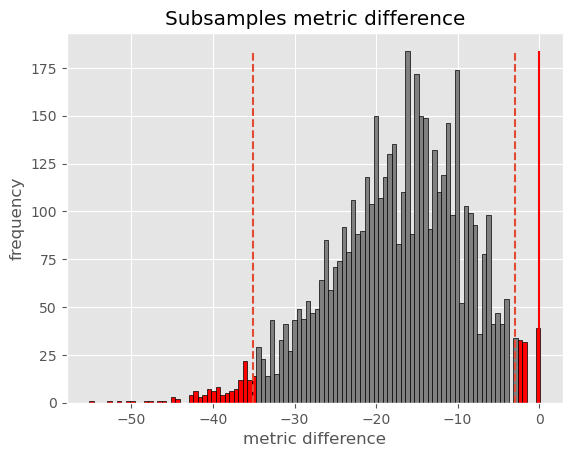

In [60]:
_ = bootstrap_test(
    df.query('group == "Control"').value, 
    df.query('group == "Treatment"').value
)

=> для исходных выборок 0 не входит в ДИ разницы средних\
=> между исходными выборками имеются статзначимые различия

  0%|          | 0/5000 [00:00<?, ?it/s]

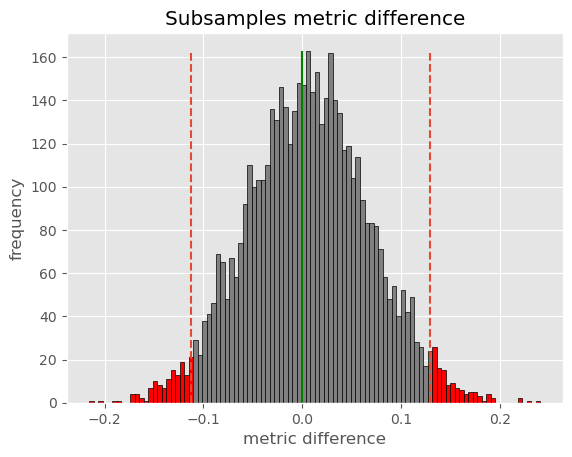

In [61]:
_ = bootstrap_test(
    fixed_df.query('group == "Control"').value, 
    fixed_df.query('group == "Treatment"').value
)

=> для выборок без выбросов 0 входит в ДИ разницы средних\
=> bootstrap не позволяет отвергнуть H0 для выборок без выбросов

#### Медианы

  0%|          | 0/5000 [00:00<?, ?it/s]

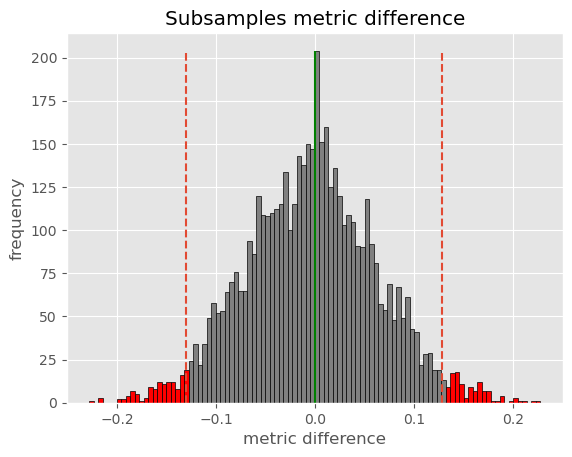

In [62]:
_ = bootstrap_test(
    df.query('group == "Control"').value, 
    df.query('group == "Treatment"').value,
    statistic_func=np.median
)

=> для исходных выборок 0 не входит в ДИ для разницы медиан \
=> bootstrap не позволяет отвергнуть H0

-----------------

# Выводы

#### Выводы по использованию методов
- Для применения "в лоб" в данной задаче подходят лишь U-тест и бутстрап (в силу их нетребовательности)
- При этом U-тест и бутстрап дают разные результаты для исходных выборок
- Bootstrap даёт различные результаты в зависимости от использования разницы средних или медиан

#### Выводы по AB тесту
- прибыль с основной массы пользователей не изменилась
- если эксперимент построен корректно, то нововведения в продукт привели к появлению нескольких аномально прибыльных сделок (единственное отличие выборок)

Inspired by: KCM7L9P

### Идеи для улучшения:
- расчёт p-value для bootstrap в общем виде